In [1]:
import torch
from hwsnn.rsnn import RSNN, RSNN_2l, RSNN_2l_ALIF
from hwsnn.utils import train, training_plots, ModelLoader
from hwsnn.tonic_dataloader import DatasetLoader
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print ('Running on: {}'.format(device))

Running on: cuda:0


In [2]:
dataset = 'shd' 
time_window = 50
batch_size = 256 # lr=1e-4
DL = DatasetLoader(dataset=dataset, caching='memory', num_workers=0, batch_size=batch_size, time_window=time_window)
data = DL.get_dataloaders()

### Fixed-structure Recurrent SNNs
There are three classes for 'fixed structure' SNNs, located in *hwsnn.rsnn*
- **RSNN**: 1 hidden recurrent
- **RSNN_2l**: 2 hidden recurrent layers
- **RSNN_2l_ALIF**: 2 hidden recurrent layers + adaptive threshold

Their initialization arguments are:
- **dataset used**: Name of the dataset. It is used for the SNN to know the input/output dimensionality. either:
    - nmnist
    - smnist
    - shd
    - DVSGesture_32
    - DVSGesture
    - custom_{num_input}_{num_outputs}_{num_training_samples}
- **num_hidden**: Number of neuron in the hidden layer(s)
- **thresh**: Neuron's threshold (or baseline theshold for the ALIF)
- **tau_m**: The membrane's time constant Either:
    - str-> 'adp', for trainable time constant [default]
    - float-> A real positive number to make all time constants fixed to that value, and untrainable
- **win**: Number of timesteps per sample. Set it to be the same as the one used in your dataset.
- **surr**: Surrogate function used: can be either:
    - 'step' [default] 
    - 'fs': fast sigmoid,
    - 'mg': multi-gaussian
- **loss_fn**: The method to compute the loss function can be either
    - mot [default]: the winner output neuron is the one with maximum membrane potential over time. Neurons have infinite threshold (never fire). It uses nn.CrossEntropyLoss()
    - sum of spikes: the winner output neuron is the one which fires the most. It uses nn.MSELoss()
    - prediction: Used for the addition task and similar. The loss is computed as the nn.MSELoss() between a reference and a single output's neuron membrane potential in the 20% last timesteps.
- **batch_size**: batch size
- **device**: cuda or cpu
- **debug**: boolean, set True if you want to store internal states (membrane and spikes) for all neurons and layers. Uses more memory, so it's recommended for testing.
 

#### Instantiation
Let's use a typical 2-layer RSNN, and name is as 'rsnn_2l_example2.t7

In [3]:
snn = RSNN_2l(dataset, num_hidden=128, thresh=0.3, tau_m='adp', win=time_window, surr='fs', loss_fn ='mot', batch_size=256, device=device)
snn.modelname = 'rsnn_2l_example2.t7'
snn.to(device)

RSNN_2l(
  (criterion): CrossEntropyLoss()
  (fc_ih): Linear(in_features=700, out_features=128, bias=False)
  (fc_h1h1): Linear(in_features=128, out_features=128, bias=False)
  (fc_h1h2): Linear(in_features=128, out_features=128, bias=False)
  (fc_h2h2): Linear(in_features=128, out_features=128, bias=False)
  (fc_ho): Linear(in_features=128, out_features=20, bias=False)
)

#### Accessing layers
Just as with any pythorch neural network, you can access their layers and weights

In [4]:
print(snn.fc_h1h1)
print(snn.fc_h1h2)
print(snn.fc_h2h2.weight.data)

Linear(in_features=128, out_features=128, bias=False)
Linear(in_features=128, out_features=128, bias=False)
tensor([[ 0.0206, -0.0578,  0.0480,  ..., -0.0608,  0.0531, -0.0811],
        [ 0.0541, -0.0509,  0.0109,  ...,  0.0185, -0.0504, -0.0460],
        [-0.0867, -0.0739,  0.0534,  ...,  0.0524, -0.0624,  0.0673],
        ...,
        [-0.0085, -0.0442, -0.0266,  ...,  0.0174, -0.0592,  0.0746],
        [-0.0285, -0.0810, -0.0170,  ...,  0.0162, -0.0649,  0.0343],
        [-0.0476,  0.0235,  0.0531,  ..., -0.0522,  0.0534,  0.0554]],
       device='cuda:0')


Also the membrane's tau are accessible.\
Note: For RSNN_2l and RSNN_2l_Alif these are not the proper membrane taus. \
alpha = sigmoid(tau_m_h) \
alpha = exp(-1/proper_tau) \
proper_tau = -1/log(alpha) \
proper_tau = -1/log(sigmoid(tau_m_h))

In [5]:
print(snn.tau_m_h_1)
print(snn.tau_m_h_2)

Parameter containing:
tensor([ 4.9106, 15.5612, 24.7288, 48.0478, 20.1697,  8.2950, 18.1227, 35.4783,
         4.3008, 18.3531, 14.2551, 45.1276, 49.0659, 16.7607, 22.4851, 37.0756,
        18.5447, 32.2890,  7.7051,  7.4887, 22.2383, 35.7862, 45.6630, 35.1041,
        47.4852, 45.9907, 45.7660,  2.5605,  5.1486, 46.8776, 39.0435, 10.8299,
        22.2391, 16.6618,  7.4593,  7.1570, 14.7571, 30.6294, 32.6660, 32.9550,
        27.6427, 31.0796, 11.7376, 30.7403, 30.8733, 34.6709, 38.1450, 35.7206,
        40.9281, 31.0398, 12.3805, 18.1398, 18.2671, 34.2077, 41.5827, 31.8401,
         8.2150, 34.2188,  3.6938, 19.0251, 38.1387, 28.0309,  1.3935, 13.8576,
        17.3920, 30.0481,  7.4557, 35.2314, 17.1932, 14.0553,  4.8229, 44.0909,
        35.8135, 42.1939, 15.4776,  6.5091, 12.9670, 28.4594, 10.8062, 18.5353,
        34.6849, 40.3866, 41.8989, 34.8073,  2.4972,  2.4398, 45.2097, 48.3116,
        24.1264, 33.2488, 35.3032, 17.4775, 42.2275,  8.0002,  8.8815, 49.6446,
         9.4871,  

#### Plotting distributions

use **plot(parameter, mode: 'matrix' or 'histogram')** if you want to plot the parameters individually

<AxesSubplot:>

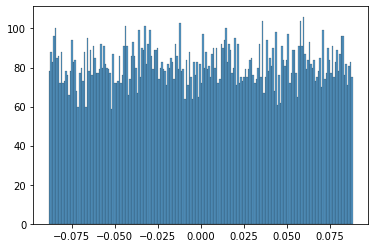

In [6]:
snn.plot(snn.fc_h1h1, 'histogram')

<AxesSubplot:title={'center':'weights'}, xlabel='input', ylabel='output'>

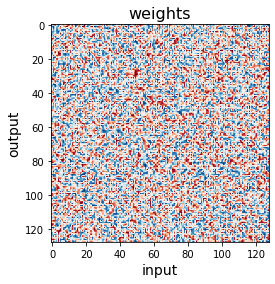

In [7]:
snn.plot(snn.fc_h1h1, 'matrix')

For a more sumarized graph, use **plot_distributions(mode: 'weights' or 'taus')**

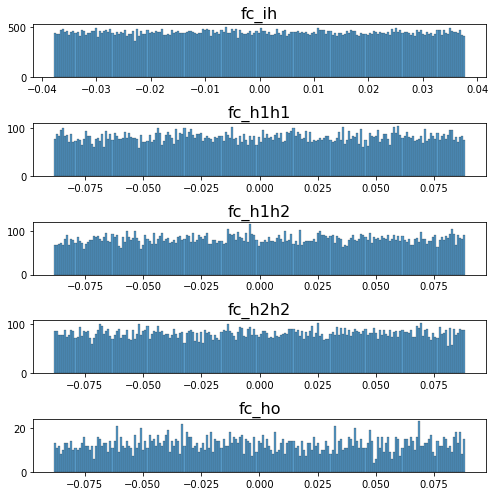

In [8]:
ax = snn.plot_distributions()

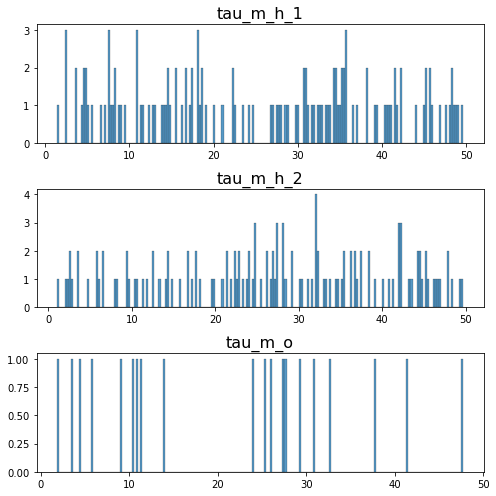

In [9]:
ax = snn.plot_distributions('taus')

In [10]:
ckpt_dir = 'examples'
train(snn, data, learning_rate=1e-3, lr_scale = (5.0, 5.0), num_epochs=50, ckpt_dir=ckpt_dir)

RSNN_2l(
  (criterion): CrossEntropyLoss()
  (fc_ih): Linear(in_features=700, out_features=128, bias=False)
  (fc_h1h1): Linear(in_features=128, out_features=128, bias=False)
  (fc_h1h2): Linear(in_features=128, out_features=128, bias=False)
  (fc_h2h2): Linear(in_features=128, out_features=128, bias=False)
  (fc_ho): Linear(in_features=128, out_features=20, bias=False)
)
Total params: 141312
Total mult-adds (M): 7.0656
training rsnn_2l_example2.t7 for 50 epochs...
Epoch [1/50]
Step [10/31], Loss: 266.78226
Step [20/31], Loss: 191.96539
Step [30/31], Loss: 128.12038
Time elasped: 57.93503975868225
Epoch [2/50]
Step [10/31], Loss: 85.12339
Step [20/31], Loss: 71.49017
Step [30/31], Loss: 52.59683
Time elasped: 7.541506052017212
Epoch [3/50]
Step [10/31], Loss: 44.08521
Step [20/31], Loss: 41.81279
Step [30/31], Loss: 40.49335
Time elasped: 5.772489309310913
Epoch [4/50]
Step [10/31], Loss: 38.64944
Step [20/31], Loss: 37.09811
Step [30/31], Loss: 35.74922
Time elasped: 5.786366939544678

#### Tau distribution after training

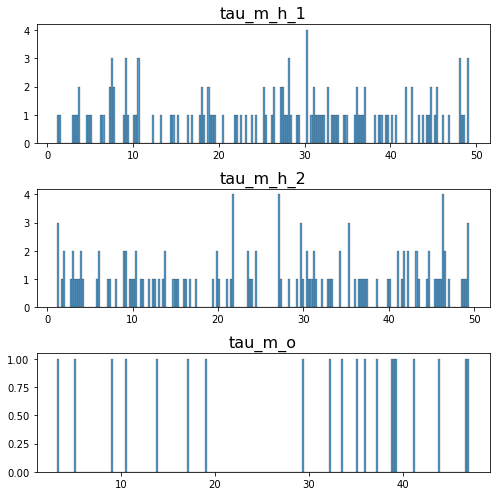

In [15]:
ax = snn.plot_distributions('taus')